In the notebook "[Cleaning the data for rapid prototyping](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai)" I showed how to create a small, fast, ready-to-use dataset for prototyping our models. The dataset created in that notebook, along with the metadata files it uses, are now [available here](https://www.kaggle.com/jhoward/rsna-hemorrhage-tif).

So let's use them to create a model! In this notebook we'll see the whole journey from pre-training using progressive resizing on our prototyping sample, through to fine-tuning on the full dataset, and then submitting to the competition.

In my testing overnight with this notebook on my local machine I was seeing scores that would land towards the top of the leaderboard with a single model, with just some minor tweaking. I'm intentionally not doing any tricky modeling in this notebook, because I want to show the power of simple techniques and simples architectures. You should take this as a starting point and experiment! e.g. try data augmentation methods, architectures, preprocessing approaches, using the DICOM metadata, and so forth...

We'll be using the fastai.medical.imaging library here - for more information about this see the notebook [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai). We'll also use the same basic setup that's in the notebook.

In [1]:
!pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/fastai/fastai_dev                    > /dev/null

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-iwn2mq83


In [2]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *
from fastai2.callback.tracker import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'

First we read in the metadata files (linked in the introduction).

In [3]:
path = Path('../input/rsna-intracranial-hemorrhage-detection/')
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

path_inp = Path('../input')
path_xtra = path_inp/'rsna-hemorrhage-tif'
path_meta = path_xtra/'meta'/'meta'
path_tif = path_xtra/'train_tif'/'train_tif'

In [4]:
df_comb = pd.read_feather(path_meta/'comb.fth')
df_tst  = pd.read_feather(path_meta/'df_tst.fth').set_index('SOPInstanceUID')
df_samp = pd.read_feather(path_meta/'wgt_sample.fth').set_index('SOPInstanceUID')
bins = (path_meta/'bins.pkl').load()

## Prepare sample DataBunch

Our first task is to create a `DataBunch` that contains our sample data. We'll need a function to convert a filename (pointing at a DICOM file) into a path to our sample TIFF files:

In [5]:
def tif_fn(fn): return path_tif/(os.path.splitext(os.path.basename(fn))[0]+'.tif')
fns = L(tif_fn(o) for o in df_samp.fname.values)
fn = fns[0]

We also need to be able to grab the labels from this, which we can do by simply indexing into our sample `DataFrame`.

In [6]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_samp.loc[Path(fn).with_suffix('').name][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 1., 1., 0., 0.], dtype=float32)

If you have a larger GPU or more workers, change batchsize and number-of-workers here:

In [7]:
bs,nw = 128,4

We're going to use fastai's new [Transform Pipeline API](http://dev.fast.ai/pets.tutorial.html) to create the DataBunch, since this is extremely flexible, which is great for intermediate and advanced Kagglers. (Beginners will probably want to stick with the Data Blocks API). We create two transform pipelines, one to open the TIFF image file, and one to look up the label and create a tensor of categories.

In [8]:
tfms = [[PILCTScan.create], [fn2label,EncodedMultiCategorize(htypes)]]
split_idx = RandomSplitter()(fns)
dsrc = DataSource(fns, tfms, splits=split_idx)
# I took the mean/std of a single batch to get these approximate values
nrm = Normalize(tensor([0.6]),tensor([0.25]))
# Since we have 16 bit data we have to divide by 2**16 to convert to the range (0,1)
batch_tfms = [IntToFloatTensor(div=2.**16), nrm, Cuda()]

To support progressive resizing (one of the most useful tricks in the deep learning practitioner's toolbox!) we create a function that returns a dataset resized to a requested size:

In [9]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_item=[ToTensor],
                          after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

Let's try it out!

(tensor(0.0267), tensor(1.0699), torch.Size([128, 1, 96, 96]))

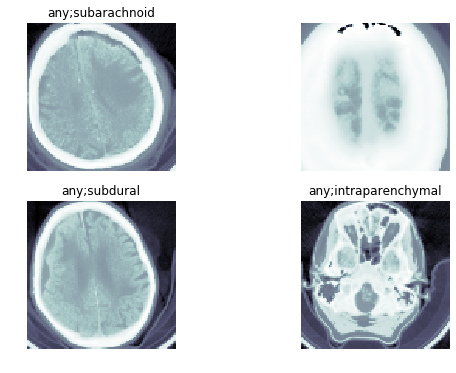

In [10]:
dbch = get_data(128, 96)
xb,yb = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std(),xb.shape

Let's track the accuracy of the *any* label as our main metric, since it's easy to interpret.

In [11]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

The loss function in this competition is weighted, so let's train using that loss function too.

In [12]:
loss_weights = tensor(2.0, 1, 1, 1, 1, 1).cuda()
loss_func = BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
    is_2d=False, activation=torch.sigmoid)
opt_func = partial(Adam, wd=0.01, eps=1e-3)
metrics=[accuracy_multi]

Here's a handy trick: we can use a pretrained model (resnet34, in this case), and convert it to 1-channel, by simply taking the average of the initial convolutional layer!

In [13]:
def get_learner():
    learn = cnn_learner(dbch, resnet18, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    w = learn.model[0][0].weight
    w.data = w.mean(1,keepdim=True)
    # This is all that's needed to use mixed precision training in fastai :)
    return learn.to_fp16()

In [14]:
learn = get_learner()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.8MB/s]


Leslie Smith's famous LR finder will give us a reasonable learning rate suggestion.

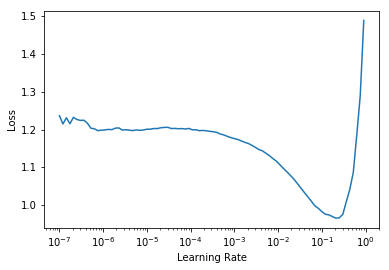

In [15]:
lrf = learn.lr_find()

## Pretrain on sample

Here's our main routine for changing the size of the images in our DataBunch, doing one fine-tuning of the final layers, and then training the whole model for a few epochs.

In [16]:
# You can add additional callbacks here as needed
cbs = []

def do_fit(bs,sz,epochs,lr):
    learn.dbunch = get_data(bs, sz)
    learn.opt.clear_state()
    learn.freeze()
    learn.fit_one_cycle(1, slice(lr), cbs=cbs)
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr), cbs=cbs)
    return learn

Now we can train at 3 different sizes. Change the number of epochs below to something other than `1` - I'm just using one epoch here for demonstration, since I'm nearly out of GPU hours this week.

In [17]:
learn = do_fit(128, 96, 1, 1e-2)
learn.save('s1')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.393361,0.379392,0.835371,09:52


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.288758,0.280219,0.887423,09:54


In [18]:
learn = do_fit(128, 160, 1, 3e-3)
learn.save('s2')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.308194,0.306662,0.874754,09:44


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.256738,0.253307,0.900946,09:31


In [19]:
learn = do_fit(128, 256, 1, 1e-3)
learn.save('s3')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.294192,0.288351,0.884910,09:32


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.249876,0.248344,0.903287,10:02


## Scale up to full dataset

Now let's fine tune this model on the full dataset. We'll need all the filenames now, not just the sample.

In [20]:
fns = df_comb.fname.values
fn = fns[0]

To get better validation measures, we should split on patients, not just on studies, since that's how the test set is created.

In [21]:
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]
len(pat_trn)

13680

In [22]:
df_trn = df_comb[ df_comb.PatientID.isin(pat_trn)]
df_val = df_comb[~df_comb.PatientID.isin(pat_trn)]
len(df_trn),len(df_val)

(541077, 133180)

In [23]:
df_comb.set_index('SOPInstanceUID', inplace=True)

These functions are copied nearly verbatim from our [earlier cleanup notebook](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai), so have a look there for details.

In [24]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000
    
def dcm_tfm(fn): 
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return TensorCTScan(x.hist_scaled(bins)[None])

def fn2label(fn): return df_comb.loc[Path(fn).with_suffix('').name][htypes].values.astype(np.float32)

Our DataBunch creation is nearly identical to before, but uses our cleanup function and patient-level training/validation sets.

In [25]:
trn_fns = [path_trn/Path(fn).name for fn in fns]
tfms = [[dcm_tfm], [fn2label,EncodedMultiCategorize(htypes)]]
split_idx = [df_trn.index.values,df_val.index.values]
dsrc = DataSource(trn_fns, tfms, splits=split_idx)
batch_tfms = [nrm, Cuda()]

This function is nearly the same as before, except that if we're not doing any resizing, then we skip that transform entirely.

In [26]:
def get_data(bs, sz=None):
    bt = batch_tfms
    if sz is not None: bt = bt+[AffineCoordTfm(size=sz)]
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=bt)

Now we can test it out:

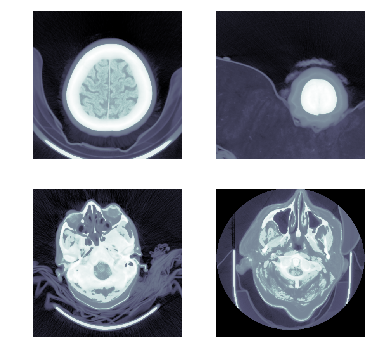

In [27]:
dbch = get_data(128, 384)
x,y = to_cpu(dbch.one_batch())
x.shape
dbch.show_batch(max_n=4)

Looks good! Let's pop it in our learner, and we're ready to train.

In [28]:
learn.dbunch = dbch
learn.opt.clear_state()

For fine-tuning the final layers, we don't really need to use a whole epoch, so we'll use the `ShortEpochCallback` to just train for 10% of an epoch, before then unfreezing the model and training a bit more.

I've commented out the final fine-tuning here since I'm nearly out of GPU time for this week!

In [29]:
# lr = 1e-3
# learn.freeze()
# learn.fit_one_cycle(1, slice(lr), cbs=[ShortEpochCallback(pct=0.1, short_valid=False)])
# learn.unfreeze()
# learn.fit_one_cycle(1, slice(lr))

And finally train a little more on the full size.

In [30]:
# dbch = get_data(128, None)
# learn.dbunch = dbch
# learn.opt.clear_state()
# lr = 1e-4
# learn.freeze()
# learn.fit_one_cycle(1, slice(lr), cbs=[ShortEpochCallback(pct=0.05, short_valid=False)])
# learn.unfreeze()
# learn.fit_one_cycle(1, slice(lr))

In [31]:
# learn.save('done')

## Prepare for submission

Now we're ready to submit. We can use the handy `test_dl` function to get an inference `DataLoader` ready, then we can check it looks OK.

In [32]:
fns = df_tst.fname.values
tst_fns = [path_tst/Path(fn).name for fn in fns]

tst = test_dl(dbch, tst_fns)
x = tst.one_batch()[0]
x.min(),x.max()

(tensor(-2.4000, device='cuda:0'), tensor(1.6000, device='cuda:0'))

We pass that to `get_preds` to get our predictions, and then clamp them just in case we have some extreme values.

In [33]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.0001, .999)

I'm too lazy to write a function that creates a submission file, so this code is stolen from Radek, with minor changes.

In [34]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
df_csv.to_csv(f'submission.csv', index=False)
df_csv.head()

,ID,Label
0,ID_e3674b189_any,0.1227333397
1,ID_e3674b189_epidural,0.0051196762
2,ID_e3674b189_intraparenchymal,0.0305598620
3,ID_e3674b189_intraventricular,0.0020748670
4,ID_e3674b189_subarachnoid,0.0177122988


Run the code below if you want a link to download the submission file.

In [35]:
from IPython.display import FileLink, FileLinks
# FileLink('submission.csv')